# Using InceptionV3 as a base model for transfer learning

Now that I've trained a simple model using InceptionV3 as a base, using only one Dense layer before output, I'd like to iterate on it to see how I can improve it. I'll be doing the same for VGG-16 and comparing the two in order to make a final decision for my best model.

In [11]:
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras.layers import Dense, Flatten, Dropout
from keras.applications.inception_v3 import InceptionV3
from pickle import dump

from functions import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data

In [20]:
# Image folder for training
train_dir = 'input_images/full_combined'
val_dir = 'input_images/validation'

# Delete metadata files created by Mac OS
!find . -name ".DS_Store" -delete

In [21]:
# Make generators -- NOW USING SEPARATE VALIDATION SET/FOLDER (see split-folders.ipynb for details)
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   horizontal_flip=True,
                                   rotation_range=20, 
                                   brightness_range=[0.5, 1.5], 
                                   zoom_range=.2)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_dir, class_mode='binary')
val_gen = val_datagen.flow_from_directory(val_dir, class_mode='binary', shuffle=False)

Found 1619 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


### Instantiate base model

I'll use the InceptionV3 model without its original Dense layers for feature extraction. I'll then add my own Dense layers and sigmoid activation output.

In [22]:
# Get base model
incep_base_model = InceptionV3(weights='imagenet', 
                               include_top=False,
                               input_shape=(256, 256, 3))

# Freeze layers
for layer in incep_base_model.layers:
    layer.trainable = False
    
# Check architecture
incep_base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, 127, 127, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_282 (BatchN (None, 127, 127, 32) 96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 127, 127, 32) 0           batch_normalization_282[0][0]    
_______________________________________________________________________________________

## Iterations

Before, I simply added one Dense(512) layer on top of the base architecture.

I'll use `train_gen` and `val_gen` as defined above.

### Top with 2 Dense(512) layers 

In [15]:
# Instantiate model
incep_1 = models.Sequential()

# Add base model
incep_1.add(incep_base_model)

# Flatten the output layer to 1 dimension
incep_1.add(Flatten())

# Add 2 fully connected layers with 512 hidden units and ReLU activation
incep_1.add(Dense(512, activation='relu'))
incep_1.add(Dense(512, activation='relu'))

# Add a final sigmoid layer with 1 node for classification output
incep_1.add(Dense(1, activation='sigmoid'))

# Compile
incep_1.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['acc', 'Recall', 'Precision'])

In [16]:
# Train the model
incep_1_history = incep_1.fit(train_gen,
                              epochs=20,
                              validation_data=val_gen)

Epoch 1/20
51/51 [==============================] - 235s 5s/step - loss: 3.9878 - acc: 0.7381 - recall: 0.7561 - precision: 0.7526 - val_loss: 0.3927 - val_acc: 0.8800 - val_recall: 0.7600 - val_precision: 1.0000
Epoch 2/20
51/51 [==============================] - 221s 4s/step - loss: 0.5851 - acc: 0.8153 - recall: 0.8258 - precision: 0.8267 - val_loss: 0.3028 - val_acc: 0.8900 - val_recall: 0.7800 - val_precision: 1.0000
Epoch 3/20
51/51 [==============================] - 218s 4s/step - loss: 0.3681 - acc: 0.8493 - recall: 0.8502 - precision: 0.8642 - val_loss: 0.3257 - val_acc: 0.8900 - val_recall: 0.7800 - val_precision: 1.0000
Epoch 4/20
51/51 [==============================] - 216s 4s/step - loss: 0.3332 - acc: 0.8734 - recall: 0.8699 - precision: 0.8895 - val_loss: 0.2410 - val_acc: 0.9000 - val_recall: 0.9200 - val_precision: 0.8846
Epoch 5/20
51/51 [==============================] - 216s 4s/step - loss: 0.4002 - acc: 0.8518 - recall: 0.8490 - precision: 0.8692 - val_loss: 0.261

In [17]:
incep_1.save('models/incep_1.h5')

Training eval:
51/51 [==============================] - 216s 4s/step - loss: 0.2104 - acc: 0.9092 - recall: 0.9663 - precision: 0.8758

Validation eval:
4/4 [==============================] - 7s 2s/step - loss: 0.1752 - acc: 0.9100 - recall: 0.9400 - precision: 0.8868


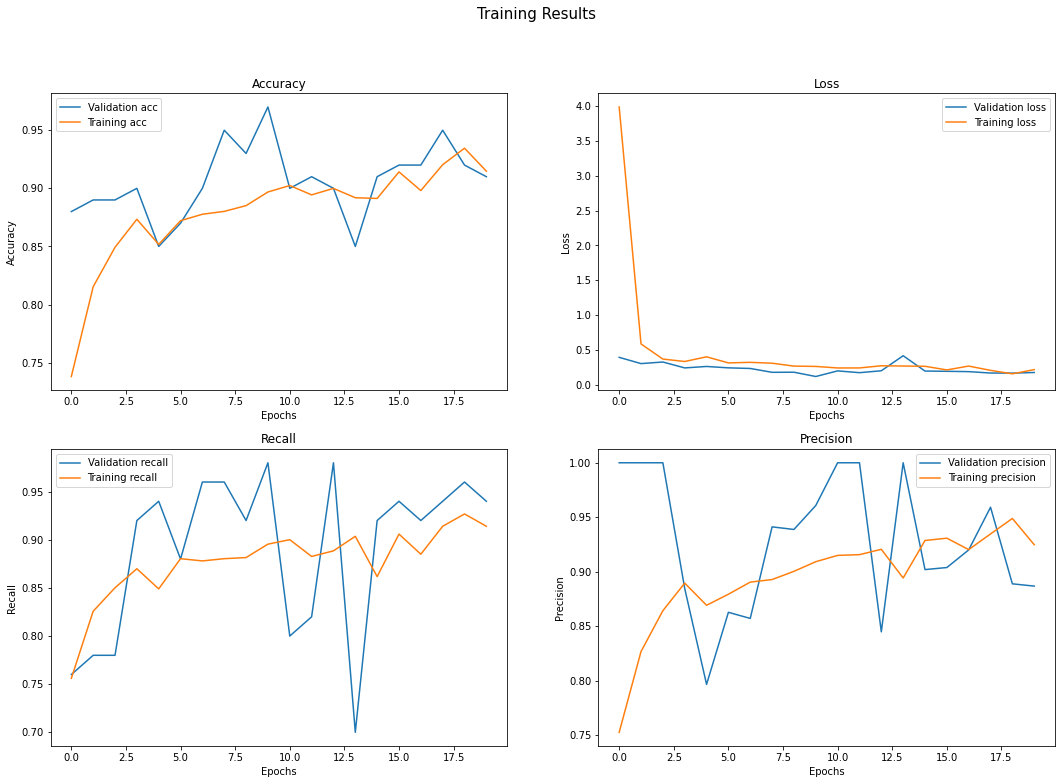

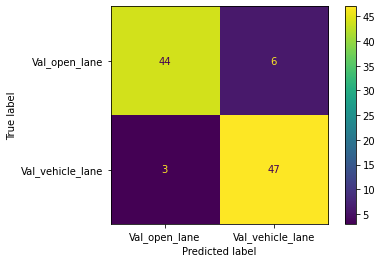

In [18]:
visualize_results(incep_1_history, incep_1, train_gen, val_gen)

In [19]:
dump(incep_1_history.history, open('models/incep_1_history.pkl', 'wb'))

Wow, the InceptionV3 models are significantly faster than VGG-16 by up to over a minute per epoch! InceptionV3 models have a much steeper descent in loss right away. It also looks like possibly more training could further improve the metrics, but I'm also worried about overfitting.

### 2 Dense layers and aggressive (0.5) Dropout to avoid overfitting

In [28]:
# Instantiate model
incep_2 = models.Sequential()

# Add base model
incep_2.add(incep_base_model)

# Flatten the output layer to 1 dimension
incep_2.add(Flatten())

# Add 2 fully connected layers with 512 hidden units and ReLU activation,
# plus Dropout layers
incep_2.add(Dense(512, activation='relu'))
incep_2.add(Dropout(0.5))
incep_2.add(Dense(512, activation='relu'))
incep_2.add(Dropout(0.5))

# Add a final sigmoid layer with 1 node for classification output
incep_2.add(Dense(1, activation='sigmoid'))

# Compile
incep_2.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['acc', 'Recall', 'Precision'])

In [29]:
# Train the model
incep_2_history = incep_2.fit(train_gen,
                              epochs=20,
                              validation_data=val_gen)

Epoch 1/20
51/51 [==============================] - 383s 8s/step - loss: 8.1986 - acc: 0.7332 - recall: 0.7480 - precision: 0.7497 - val_loss: 1.1771 - val_acc: 0.8600 - val_recall: 0.9400 - val_precision: 0.8103
Epoch 2/20
51/51 [==============================] - 374s 7s/step - loss: 1.9615 - acc: 0.7702 - recall: 0.7933 - precision: 0.7788 - val_loss: 0.3042 - val_acc: 0.8500 - val_recall: 0.9000 - val_precision: 0.8182
Epoch 3/20
51/51 [==============================] - 370s 7s/step - loss: 0.5366 - acc: 0.7752 - recall: 0.7236 - precision: 0.8318 - val_loss: 0.2612 - val_acc: 0.8800 - val_recall: 0.8800 - val_precision: 0.8800
Epoch 4/20
51/51 [==============================] - 383s 8s/step - loss: 0.4582 - acc: 0.8011 - recall: 0.7213 - precision: 0.8834 - val_loss: 0.2671 - val_acc: 0.8900 - val_recall: 0.8400 - val_precision: 0.9333
Epoch 5/20
51/51 [==============================] - 386s 8s/step - loss: 0.4768 - acc: 0.8147 - recall: 0.7410 - precision: 0.8923 - val_loss: 0.300

In [30]:
incep_2.save('models/incep_2.h5')

Training eval:
51/51 [==============================] - 371s 7s/step - loss: 0.3247 - acc: 0.8382 - recall: 0.7247 - precision: 0.9615

Validation eval:
4/4 [==============================] - 12s 3s/step - loss: 0.3156 - acc: 0.8700 - recall: 0.7400 - precision: 1.0000


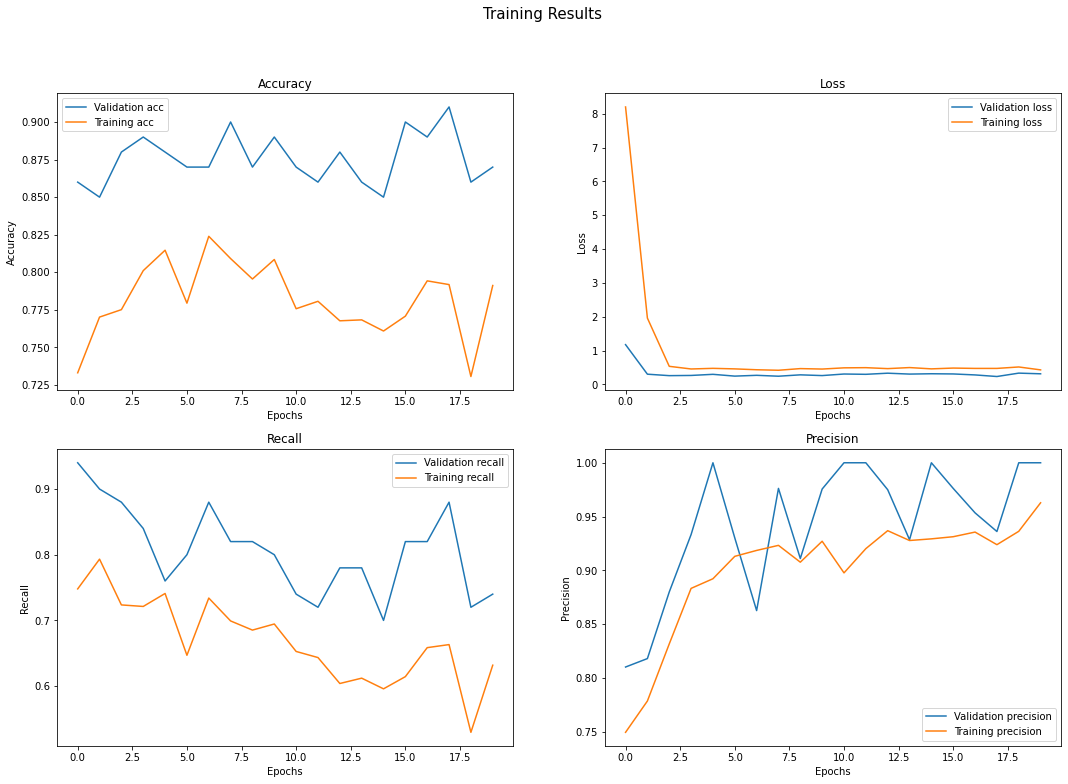

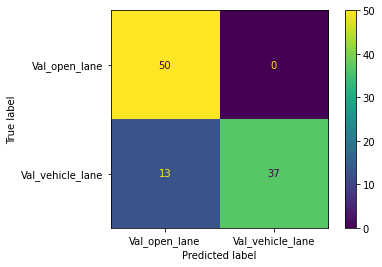

In [31]:
visualize_results(incep_2_history, incep_2, train_gen, val_gen)

In [32]:
dump(incep_2_history.history, open('models/incep_2_history.pkl', 'wb'))

Definitely worse metrics, but perhaps that means it’s not as overfit? Back to the same issue of significantly better val than training metrics. This one is not the winner.

### More Dense layers with decreasing number of nodes

In [23]:
# Instantiate model
incep_3 = models.Sequential()

# Add base model
incep_3.add(incep_base_model)

# Flatten the output layer to 1 dimension
incep_3.add(Flatten())

# Add 2 fully connected layers with 512 hidden units and ReLU activation,
# plus Dropout layers
incep_3.add(Dense(512, activation='relu'))
incep_3.add(Dense(128, activation='relu'))
incep_3.add(Dense(32, activation='relu'))

# Add a final sigmoid layer with 1 node for classification output
incep_3.add(Dense(1, activation='sigmoid'))

# Compile
incep_3.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['acc', 'Recall', 'Precision'])

In [24]:
# Train the model
incep_3_history = incep_3.fit(train_gen,
                              epochs=20,
                              validation_data=val_gen)

Epoch 1/20
51/51 [==============================] - 240s 5s/step - loss: 5.2975 - acc: 0.7202 - recall: 0.7282 - precision: 0.7411 - val_loss: 0.5410 - val_acc: 0.8700 - val_recall: 0.7400 - val_precision: 1.0000
Epoch 2/20
51/51 [==============================] - 315s 6s/step - loss: 0.7715 - acc: 0.8042 - recall: 0.8223 - precision: 0.8119 - val_loss: 1.1137 - val_acc: 0.8300 - val_recall: 0.6600 - val_precision: 1.0000
Epoch 3/20
51/51 [==============================] - 405s 8s/step - loss: 0.7095 - acc: 0.8240 - recall: 0.8281 - precision: 0.8388 - val_loss: 0.2573 - val_acc: 0.8600 - val_recall: 0.9800 - val_precision: 0.7903
Epoch 4/20
51/51 [==============================] - 394s 8s/step - loss: 0.3675 - acc: 0.8660 - recall: 0.8769 - precision: 0.8718 - val_loss: 0.2872 - val_acc: 0.8600 - val_recall: 0.9600 - val_precision: 0.8000
Epoch 5/20
51/51 [==============================] - 377s 7s/step - loss: 0.3511 - acc: 0.8746 - recall: 0.8757 - precision: 0.8871 - val_loss: 0.249

In [25]:
incep_3.save('models/incep_3.h5')

Training eval:
51/51 [==============================] - 387s 8s/step - loss: 0.1364 - acc: 0.9463 - recall: 0.9268 - precision: 0.9708

Validation eval:
4/4 [==============================] - 10s 2s/step - loss: 0.1472 - acc: 0.9300 - recall: 0.9000 - precision: 0.9574


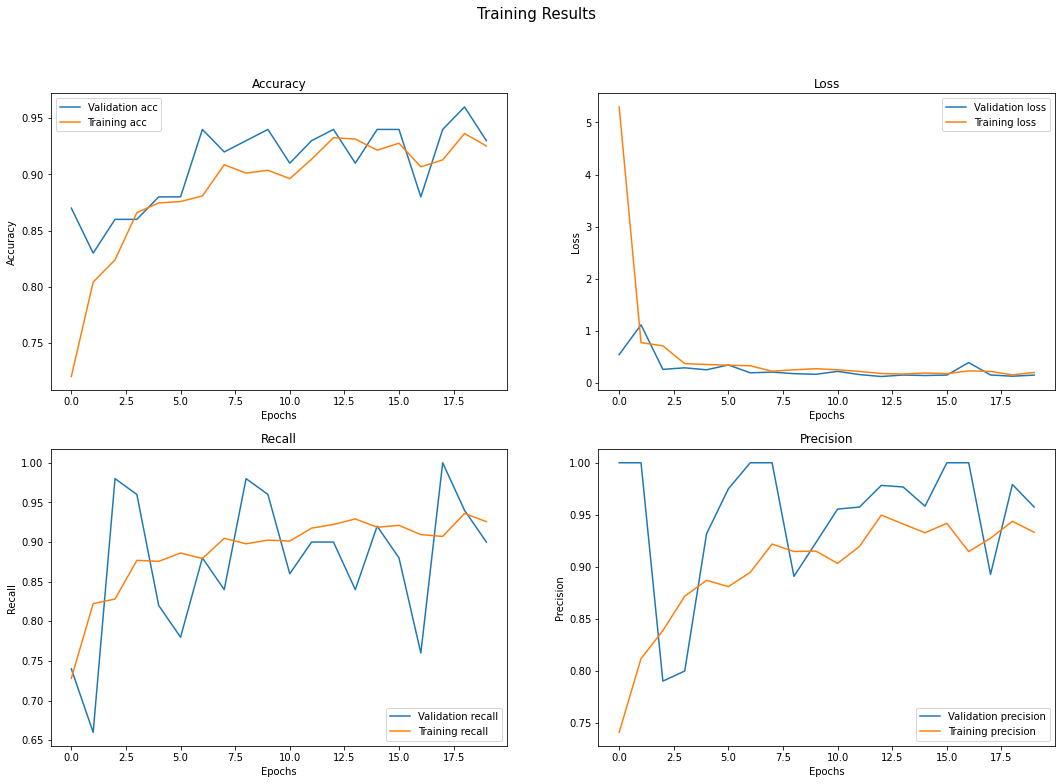

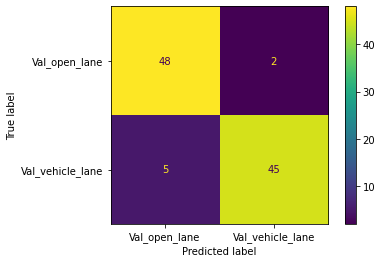

In [26]:
visualize_results(incep_3_history, incep_3, train_gen, val_gen)

In [27]:
dump(incep_3_history.history, open('models/incep_3_history.pkl', 'wb'))

This is absolutely an improvement over incep_1, but it seems to be about the same if not somewhat worse than incep_transfer_model. Comparable to vgg_3; difficult to judge because of small validation set size.